<a href="https://colab.research.google.com/github/prrmzz/TeslaStock-SimpleLSTM/blob/main/TESLA_SimpleLSTMipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import datetime

In [2]:
ticker_symbol = "TSLA"

In [3]:
import datetime
end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime.now() - datetime.timedelta(days=5*365)).strftime("%Y-%m-%d")

In [4]:
data = yf.download(ticker_symbol, start=start_date, end=end_date)
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2020-01-08  32.809334  32.809334  33.232666  31.215334  31.580000  467164500
2020-01-09  32.089333  32.089333  33.253334  31.524668  33.139999  426606000
2020-01-10  31.876667  31.876667  32.329334  31.580000  32.119331  194392500
2020-01-13  34.990665  34.990665  35.042000  32.799999  32.900002  397764000
2020-01-14  35.861332  35.861332  36.493999  34.993332  36.284000  434943000


In [5]:
close_prices = data['Close'].values.reshape(-1, 1)

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices_scaled = scaler.fit_transform(close_prices)

In [7]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [8]:
seq_length = 60
X, y = create_sequences(close_prices_scaled, seq_length)

In [9]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [11]:
model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=(seq_length, 1)),
    Dropout(0.2),
    Bidirectional(LSTM(100, return_sequences=False)),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [14]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 253ms/step - loss: 0.0503 - val_loss: 0.0066
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 253ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 233ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 226ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 20

In [15]:
loss = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 4.6023e-04
Test Loss (MSE): 0.0007322866003960371


In [16]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


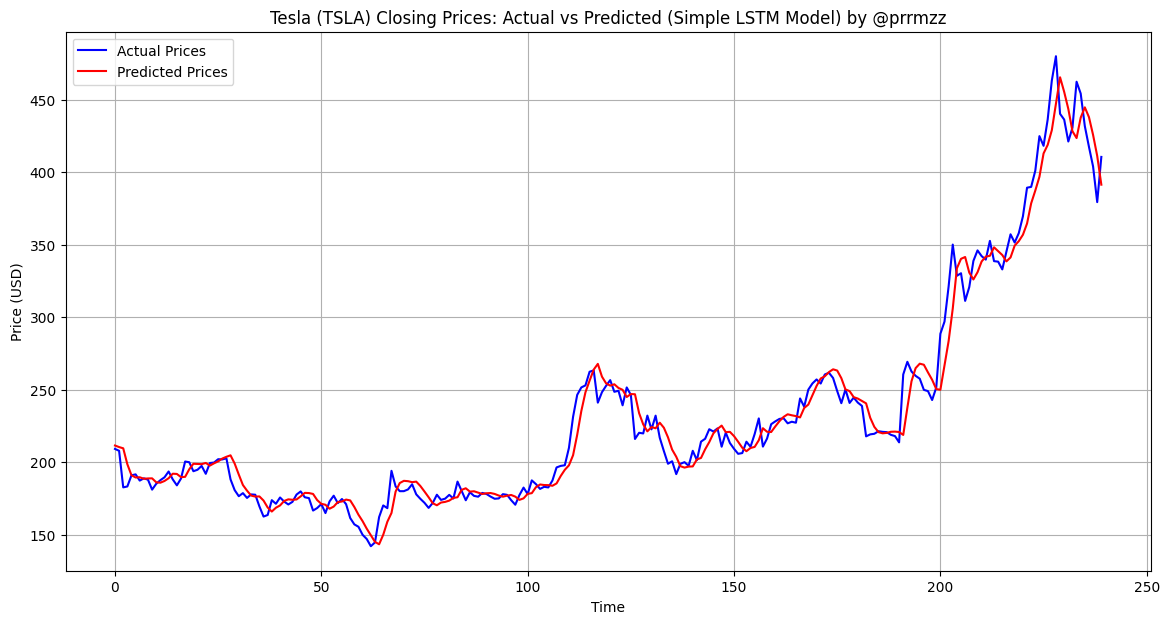

In [19]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(predictions, label='Predicted Prices', color='red')
plt.title('Tesla (TSLA) Closing Prices: Actual vs Predicted (Simple LSTM Model) by @prrmzz')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

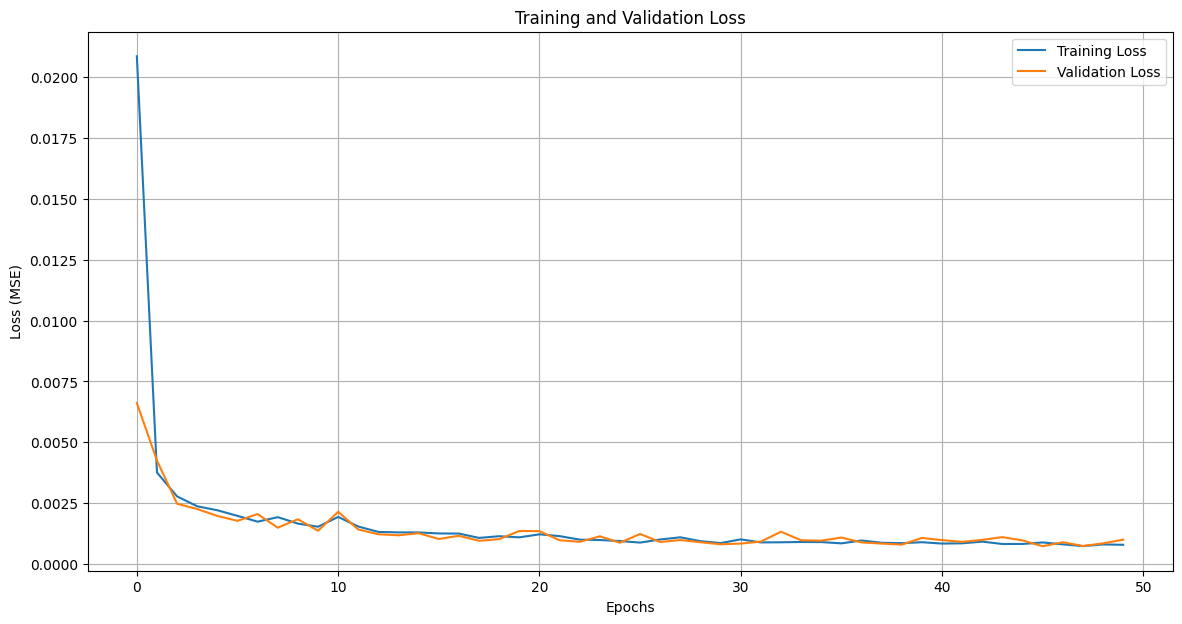

In [20]:
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()